# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest. He published his analysis in this [article](https://fivethirtyeight.com/features/fandango-movies-ratings/).

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars. Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible

## Goal
We will analyze recent movie ratings to see if there has been a change in Fandango's movie ratings system after Hickey's analyis.

## Data
To accomplish our goal, we will use two data sets to compare from two different periods of time:

- Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis

## Understanding the Data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    linewidth=1
    )


% matplotlib inline

In [2]:
early_ratings = pd.read_csv('fandango_score_comparison.csv')
late_ratings = pd.read_csv('movie_ratings_16_17.csv')

In [3]:
late_ratings.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


Let's isolate the columns that offer information about Fandango's ratings in separate variables.

In [4]:
fandango_before = early_ratings[['FILM', 'Fandango_Stars', 
                                 'Fandango_Ratingvalue', 
                                 'Fandango_votes', 
                                 'Fandango_Difference']]

fandango_after = late_ratings[['movie','year','fandango']]



In [5]:
fandango_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


When we review the README files for each dataset, we realize that the sampling process was different for each dataset, so the resulting samples are not likely to be representative of the population we were originally interested in. 

## New Goal
Because of the sampling differences, we need to change our goal. Let's determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This can serve as a proxy for our original goal.



## Isolating the Samples We Need
We now want to compare
- All Fandango's ratings for popular movies released in 2015
- All Fandango's ratings for popular movies released in 2016. 

We will consider a movie popular if it has 30 or more fan ratings on Fandango. Let's check is all of the movies contain at least 30 fan ratings.

In [8]:
fandango_before[fandango_before['Fandango_votes'] < 30].count()

FILM                    0
Fandango_Stars          0
Fandango_Ratingvalue    0
Fandango_votes          0
Fandango_Difference     0
dtype: int64

So the ```fandango_before``` dataset contains no movies that have fewer than 30 votes. The ```fandango_after``` dataset is a little more complicated because it does not include the number of fan ratings. To check this, we'll pick a random set of 10, then manually go check the number of ratings on Fandango.

In [10]:
fandango_after.sample(10,random_state=42)

,movie,year,fandango
9,Amateur Night,2016,3.5
197,The Take (Bastille Day),2016,4.0
66,"Hail, Caesar!",2016,2.5
191,The Perfect Match,2016,4.0
117,Morgan,2016,3.5
111,Miracles from Heaven,2016,4.5
15,Bad Moms,2016,4.5
86,Julieta,2016,3.5
75,Ice Age: Collision Course,2016,4.0
144,Sing Street,2016,4.5


All 10 of these movies have at least 30 votes on Fandango, so we can continue our analysis with decent confidence this sample contains what we want.

Both datasets contain movies that were released outside of 2015 or 2016. We want to focus our analysis on these years, so we need to select only the correct movies for both sets.

In [21]:
# select only the 2015 movies from fandango_before

# the year is in the FILM column, always at the end
fandango_before['Year'] = fandango_before['FILM'].str[-5:-1]
#fandango_before['Year'].value_counts()

fandango_2015 = fandango_before[fandango_before['Year'] == '2015'].copy()
#fandango_2015.head()
#fandango_2015['Year'].value_counts()


/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
# Now, select only 2016 from the fandango_after 

#fandango_after.head()

fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()



2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes

Now that we have isolated the movies we want to compare, let's begin the analysis with a high-level comparison of the distributions.

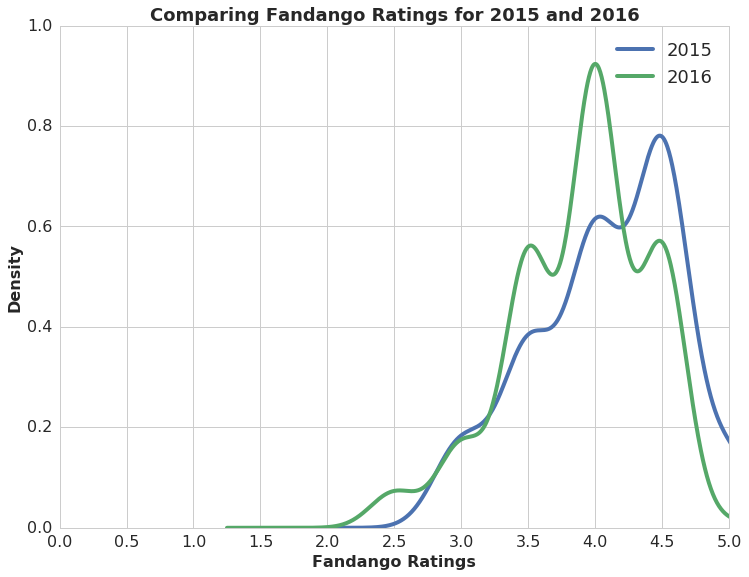

In [59]:
plt.figure(figsize=(12,9))
fandango_2015['Fandango_Stars'].plot.kde(label='2015',linewidth=4)
fandango_2016['fandango'].plot.kde(label='2016',linewidth=4)

plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
          fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,5)
plt.xlabel('Fandango Ratings',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.title('Comparing Fandango Ratings for 2015 and 2016',
          fontsize=18)
plt.legend(fontsize=18)
plt.show()

Each distribution is left skewed. There are very few movies with ratings less than 3 stars. 2015 might be slightly more heavily balanced towards higher stars than 2016. There appears to be a little more of a tail with the 2016 data on the high side compared to 2015. 

## Comparing Relative Frequencies

We now want to analyze the data more granularly to investigate this potential difference between 2015 and 2016. Since the data sets contain different numbers of movies, let's create frequency tables for both years that show percentages

In [60]:
print('2015' + '\n' + '-' * 16) # To help us distinguish between the two tables immediately and
                                # avoid silly mistakes as we read to and fro
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100


2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [61]:
print('2016' + '\n' + '-' * 16) # To help us distinguish between the two tables immediately and
                                # avoid silly mistakes as we read to and fro
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100


2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, fewer movies had high ratings of 4.5 or 5 stars. There are also more movies in 2016 that had the lowest rating of 2.5 stars. 

## Determining the Direction of the Change

We have confirmed that the two datasets have a difference in the distributions. However, the direction of the difference is not clear. Let's take a few summary statistics to get a better picture of the direction of the different. 

In [69]:
# 2015

mean_2015 = fandango_2015['Fandango_Stars'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]

std_2015 = fandango_2015['Fandango_Stars'].std()

In [70]:
# 2016

mean_2016 = fandango_2016['fandango'].mean()

median_2016 = fandango_2016['fandango'].median()

mode_2016 = fandango_2016['fandango'].mode()[0]

std_2016 = fandango_2016['fandango'].std()

In [71]:
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015, std_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016, std_2016]
summary.index = ['mean', 'median', 'mode', 'std']
summary


,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000
std,0.538096,0.509540


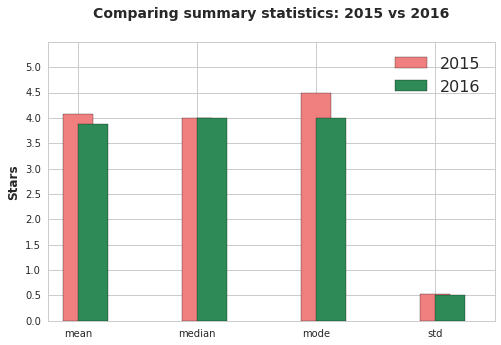

In [79]:
summary['2015'].plot.bar(color = 'lightcoral', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = 'seagreen', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper right',fontsize=16)
plt.show()

## Conclusions

There does appear to be a slight difference between Fandango ratings in 2015 and 2016. 2015 ratings were, on average, higher than 2016 ratings. We cannot state what caused the ratings to change, but the timing with Hikey's orginal article makes it possible that was the cause.